# Disclaimers

- I have no formal education in data science
- All data used is pubicly accessible via the Reddit API
- About 80% of this code (maybe more) was generated by ChatGPT

https://linkedin.com/in/caseyjohnsonwv

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os

OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
OPENAI_MODEL = os.environ['OPENAI_MODEL']

REDDIT_CLIENT_ID = os.environ['REDDIT_CLIENT_ID']
REDDIT_CLIENT_SECRET = os.environ['REDDIT_CLIENT_SECRET']
REDDIT_USERNAME = os.environ['REDDIT_USERNAME']
REDDIT_USER_AGENT = 'r/rollercoasters trip report analysis'

# Hard limit
MAX_LLM_CALLS = 500

# Gather Raw Data

Using the Python package `praw` to scrape r/rollercoasters for "trip report" posts

In [52]:
import calendar
from datetime import datetime
import re
import pandas as pd
from praw import Reddit

# Setup Reddit API with PRAW
reddit = Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT,
    username=REDDIT_USERNAME,
)

# Fetch posts from r/rollercoasters
subreddit = reddit.subreddit('rollercoasters')
posts = []

# Search for posts with "trip report" in title or body
for submission in subreddit.search("trip report", limit=MAX_LLM_CALLS):  # Adjust limit as needed
    title = submission.title
    
    # Convert created_utc to datetime object
    post_date = datetime.utcfromtimestamp(submission.created_utc)
    post_month_name = post_date.strftime('%B')
    post_year = post_date.year

    # Look for OP's top-level comment
    full_text = submission.selftext
    submission.comments.replace_more(limit=0)  # Load all comments
    for comment in submission.comments:
        if comment.is_submitter and comment.parent_id == submission.id:
            full_text = f"{full_text}\n\n{comment.body}"

    # Build post URL for reference
    post_url = f"https://reddit.com{submission.permalink}"
    
    # Append the post details to the list
    posts.append([title, post_month_name, post_year, full_text, post_url])

# Convert to a Pandas DataFrame
df = pd.DataFrame(posts, columns=['Title', 'Post Month', 'Post Year', 'Content', 'URL'])

# Drop rows where 'Content' is NaN or an empty string
df = df[df['Content'].str.strip().astype(bool)]

# Sort by month and year
df['Post Month'] = pd.Categorical(df['Post Month'], categories=list(calendar.month_name[1:]), ordered=True)
df = df.sort_values(by=['Post Year', 'Post Month'], ascending=[False, False])

# Print DataFrame preview
df = df.reset_index().drop(columns=['index'])
print(df.shape)
display(df.sample(n=5))

(183, 5)


,Title,Post Month,Post Year,Content,URL
34,Post Trip Report [SFMM],August,2024,We used another members trip route and it was ...,https://reddit.com/r/rollercoasters/comments/1...
167,[Dollywood] Trip Report,April,2024,Dollywood 4/14/24 Trip Report\n\nThis is my fi...,https://reddit.com/r/rollercoasters/comments/1...
85,Quick trip report for 7/11/24 [Mt. Olympus],July,2024,Mt Olympus is kinda out secondary home park. S...,https://reddit.com/r/rollercoasters/comments/1...
36,Trip Report: First visit to [Six Flags Great A...,August,2024,"First, a rant about how this trip turned into ...",https://reddit.com/r/rollercoasters/comments/1...
157,[Hershey Park] Trip Report (5/18),May,2024,[Hershey Park] Trip Report 5/18\n\nHello every...,https://reddit.com/r/rollercoasters/comments/1...


# Enhance Raw Data

Use `gpt-4o-mini` to extract features from the post's title and text. Examples:
- Name of the country where the park is located
- Is this their first visit? (boolean)
- Did they purchase a wait time reduction product? (boolean)
- Sentiment about food offerings (Positive, Negative, Mixed, or Neutral)

In [121]:
from openai import OpenAI
import json
import pandas as pd

# Define the prompt
prompt = """
You are tasked with analyzing a Reddit post about a theme park trip.
Based on the title and the post content provided, return a valid JSON object with the following keys:
{
    "Park Name": Name of the amusement park visited. By subreddit rules, this should be contained in [Square Brackets] in the title. It may be an abbreviation. If so, infer the true name
    "Park Continent": Continent where the park is located, based on your own knowledge
    "Solo Visit": Binary 0/1 value indicating if the poster visited the park alone
    "First Visit": Binary 0/1 value indicating if this is the poster's first visit to the park in question
    "Home Park": Binary 0/1 value indicating if this is the poster's closest amusement park to home
    "Purchased Line Skip": Binary 0/1 value indicating if the poster purchased the park's wait time reduction product
    "Storm Impact": Binary 0/1 value indicating if the poster's day was impacted by precipitation
    "Temperature Impact": Binary 0/1 value indicating if the poster's day was impacted by unusually hot or cold temperatures
    "Closures Impact": Binary 0/1 value indicating if the poster's day was impacted by unexpected ride closures
    "Ride Sentiment": Sentiment about the park's roller coasters and flat rides (choose an integer: 1 for "Positive", -1 for "Negative", or 0 for "Neutral")
    "Food Sentiment": Sentiment about the park's food (choose an integer: 1 for "Positive", -1 for "Negative", or 0 for "Neutral")
    "Crowd Sentiment": Sentiment about the park's crowd levels (choose an integer: 1 for "Positive", -1 for "Negative", or 0 for "Neutral")
    "Value Sentiment": Sentiment about whether the money spent was worth it (choose an integer: 1 for "Positive", -1 for "Negative", or 0 for "Neutral")
    "Experience Sentiment": Sentiment about the overall experience of visiting the park (choose an integer: 1 for "Positive", -1 for "Negative", or 0 for "Neutral")
}
Do not provide any other exposition. Do not use a formatted code block. Just return the exact text of the JSON.
"""

# Initialize OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

# Add new column to the existing DataFrame
df['Analysis'] = None

# Iterateively hit the LLM for analysis
for idx, row in df.head(n=MAX_LLM_CALLS).iterrows():
    title, content = row['Title'], row['Content']
    response = client.chat.completions.create(
        model=OPENAI_MODEL,
        messages=[
            {'role': 'system', 'content': prompt},
            {'role': 'user', 'content': f"Title: {title}\nContent: {content}"}
        ],
        temperature=0.0,
    )
    try:
        content = response.choices[0].message.content
        analysis = json.loads(content)
        df.at[idx, 'Analysis'] = analysis
    except json.JSONDecodeError:
        print(f"Failed to decode analysis as JSON: {content}")
        df.at[idx, 'Analysis'] = {}

# Normalize the JSON responses into separate columns
analysis_df = pd.json_normalize(df['Analysis'])

# Concatenate the original DataFrame with the new columns from the JSON responses and drop what we don't need
analyzed_df = pd.concat([df.drop(columns=['Analysis', 'Content', 'URL']), analysis_df], axis=1)

# Clean up the DataFrame a little
print(analyzed_df.shape)
analyzed_df['Park Name'] = analyzed_df['Park Name'].str.title()
display(analyzed_df.head(n=MAX_LLM_CALLS))

(183, 17)


,Title,Post Month,Post Year,Park Name,Park Continent,Solo Visit,First Visit,Home Park,Purchased Line Skip,Storm Impact,Temperature Impact,Closures Impact,Ride Sentiment,Food Sentiment,Crowd Sentiment,Value Sentiment,Experience Sentiment
0,[Carowinds] Trip Report 8/31 - An Honest Review,September,2024,Carowinds,North America,0,1,0,0,0,1,0,0,0,-1,0,0
1,Trip Report [Six Flags America],September,2024,Six Flags America,North America,1,0,1,0,0,1,1,1,1,1,1,1
2,First Visit to Hershey Park [Trip Report],September,2024,Hershey Park,North America,1,1,0,0,0,1,1,1,0,-1,-1,0
3,[Holiday World] Trip Report 9/1/24,September,2024,Holiday World,North America,0,0,0,0,0,1,0,1,1,1,1,1
4,[Dorney Park] Trip Report 24/8/2024,September,2024,Dorney Park,North America,0,1,0,0,0,0,1,1,0,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Trip report from [Seaworld Orlando] on 12/28/23,December,2023,Seaworld Orlando,North America,0,0,0,0,0,0,0,1,0,0,1,1
179,Trip report [Nagashima Spa Land] Japan,October,2023,Nagashima Spa Land,Asia,0,1,0,1,0,0,0,1,1,-1,1,1
180,First time trip to [Hershey Park] and [SFGA]! ...,July,2023,Hershey Park,North America,0,1,0,0,0,0,1,1,1,1,1,1
181,[SeaWorld Orlando] Trip Report / Rant (May 10),May,2023,Seaworld Orlando,North America,0,0,1,0,0,1,1,-1,-1,-1,-1,-1


# Prepare for Modeling

Analyze correlation between derived features.
- No features are highly correlated
- Value & Experience sentiments are moderately correlated (0.31)

Based on 183 rows of data
-----
High correlation pairs: 0
-----
Moderate correlation pairs: 1
--> Value Sentiment & Experience Sentiment


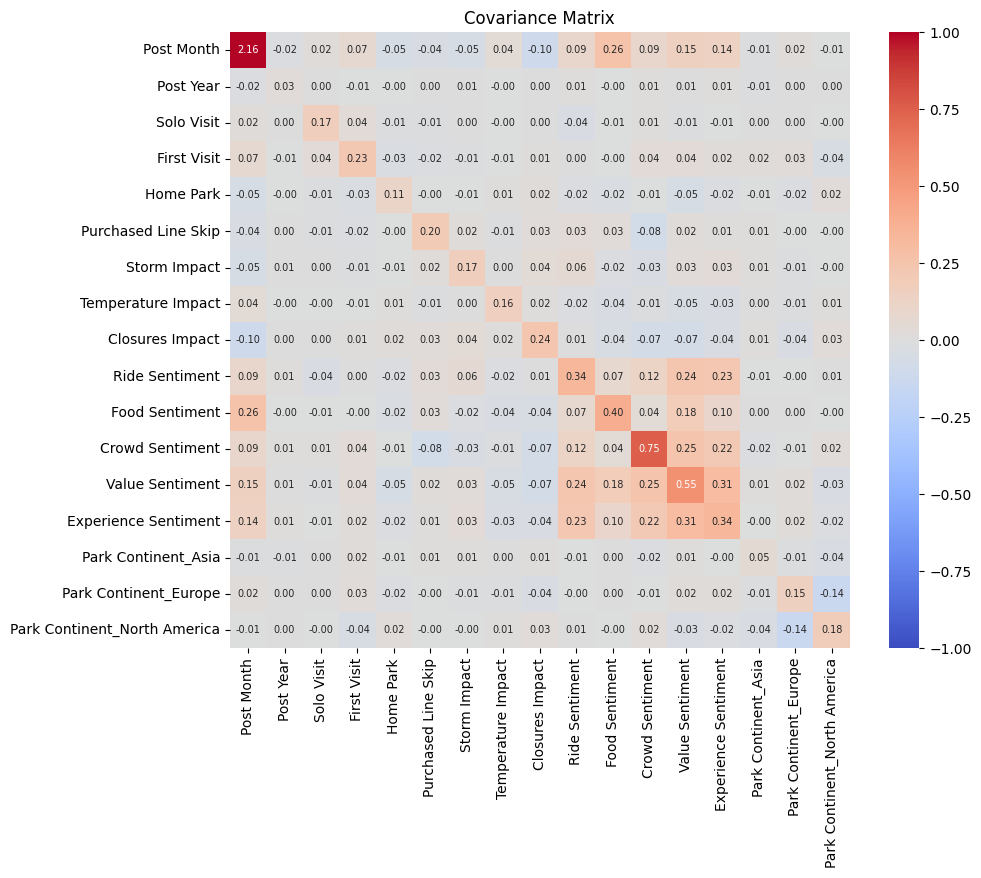

In [188]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Make a copy of the DataFrame
modeling_df = analyzed_df.copy().head(n=MAX_LLM_CALLS)

# Convert Post Month to an integer type and grab all numeric features
modeling_df['Post Month'] = pd.Categorical(modeling_df['Post Month'], categories=list(calendar.month_name[1:]), ordered=True).codes.astype(int)
numeric_features = modeling_df.select_dtypes(include=['number']).columns.tolist()

# Convert categorical continenets to numerical values using one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
location_features = ['Park Continent']
encoded_locations = encoder.fit_transform(modeling_df[location_features])
encoded_locations_df = pd.DataFrame(encoded_locations, columns=encoder.get_feature_names_out(location_features))

# Combine all features into one DataFrame
modeling_df_encoded = pd.concat([modeling_df[numeric_features], encoded_locations_df], axis=1)

# Calculate the covariance matrix
cov_matrix = modeling_df_encoded.cov()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(cov_matrix, dtype=bool), k=1)

# Find feature pairs with high or moderate correlation
print(f"Based on {modeling_df_encoded.shape[0]} rows of data")
abs_corr_matrix = np.abs(cov_matrix)
for label, threshold in [('high', 0.8), ('moderate', 0.3)]:
    corr_pairs = np.where((abs_corr_matrix > threshold) & (abs_corr_matrix < 1.0) & mask)
    corr_features = list(zip(cov_matrix.columns[corr_pairs[0]], cov_matrix.columns[corr_pairs[1]]))
    print(f"-----\n{label.title()} correlation pairs: {len(corr_features)}")
    for pair in corr_features:
        print(f"--> {pair[0]} & {pair[1]}")

# Visualize the covariance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={'size': 7})
plt.title('Covariance Matrix')
plt.show()

# Train The Model
Using Random Forest, let's try to predict:
- Value Sentiment: Was the experience worth the money?
- Experience Sentiment: Was the experience overall positive, negative, or neutral?

(I also experimented with XGBoost, but the accuracy was only marginally better.)

In [206]:
# Prepare the feature matrix and target matrix

targets = ['Value Sentiment', 'Experience Sentiment']
input_exclusions = targets + [
    'Park Continent',
    'Post Year',
    'Home Park',
    # 'Solo Visit',
]
inputs = [col for col in modeling_df_encoded.columns if not any([col.startswith(val) for val in input_exclusions])]
X = modeling_df_encoded[inputs]
y = modeling_df[targets]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set up classification model
model = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), n_jobs=-1
)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model for each target
for i, target in enumerate(targets):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"Model Accuracy for {target}: {accuracy:.2f}")

    # Cross-validation for each target separately
    clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    cv = StratifiedKFold(n_splits=5)  # Using 5 splits for cross-validation

    cv_scores = cross_val_score(clf, X, y[target], cv=cv, scoring='accuracy')
    print(f"Cross-validated Accuracy for {target}: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

    # Extract and display feature importances
    importances = model.estimators_[i].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': inputs,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    display(feature_importance_df)
    print('-----')

Model Accuracy for Value Sentiment: 0.67
Cross-validated Accuracy for Value Sentiment: 0.67 ± 0.04


,Feature,Importance
7,Ride Sentiment,0.217303
0,Post Month,0.194321
8,Food Sentiment,0.160835
9,Crowd Sentiment,0.112374
6,Closures Impact,0.062320
2,First Visit,0.058351
4,Storm Impact,0.057626
1,Solo Visit,0.049827
5,Temperature Impact,0.049518
3,Purchased Line Skip,0.037526


-----
Model Accuracy for Experience Sentiment: 0.80
Cross-validated Accuracy for Experience Sentiment: 0.77 ± 0.03


,Feature,Importance
7,Ride Sentiment,0.338186
0,Post Month,0.201825
9,Crowd Sentiment,0.132878
8,Food Sentiment,0.098068
2,First Visit,0.052929
5,Temperature Impact,0.048979
6,Closures Impact,0.042447
4,Storm Impact,0.033253
1,Solo Visit,0.027820
3,Purchased Line Skip,0.023614


-----


# Feature Lift Analysis

| Feature | Value Sentiment | Experience Sentiment |
| --- | --- | --- |
| Ride Sentiment | 21.7% | 33.8% |
| **Post Month** | **19.4%** | **20.2%** |
| Food Sentiment | 16.1% | 9.8% |
| Crowd Sentiment | 11.2% | 13.3% | 

## Discussion & New Hypotheses

I'm shocked that Post Month is so important. Seeing this, I would hypothesize that we simply grow more critical as the season wears on. Once you've visited a really good park, it's hard to tolerate visiting bad parks the rest of the summer. That probably fades when the majority of parks close during the winter. That may also influence the perpetual criticism that year-round parks like Disney and Universal face: hardcore fans are never forced to take a break. It's easy to stop appreciating the experience.

I am not surprised at all that Food Sentiment so heavily influences Value Sentiment. In most places, parks treat food service as a cash cow for their captive audiences. For example, SeaWorld Orlando recently instituted a no-reentry policy. This forces guests to remain in the park, spending 24 dollars on a medicore cheeseburger or 18 on a beer. I expected Food Sentiment to be more influential on Experience Sentiment, but I personally know enthusiasts who choose not to eat in the park when they visit - so the dataset likely contains many "Neutral" tags from the LLM data enrichment.